# Elliptical Slice Sampling without mean shifting in Numpy
This code is largely based on the code found [here](https://gist.github.com/adiehl96/d586d13ac47d7f2a3e98142b2c436ef5), which is based on the youtube video by Viking Penguin found [here](https://www.youtube.com/watch?v=HfzyuD9_gmk). However, any mention of the mean in the sampling method was removed, as it's not necessarily part of it. The credit for the example used should go to [Max Hinne](https://github.com/mhinne).

# Assumptions
* The sampler assumes that the prior is a gaussian (This can be seen in the sampling step where we have to sample from a multivariate gaussian distribution).
* The sampler assumes a prior with a zero mean, as the mean is not mentioned in this implementation.


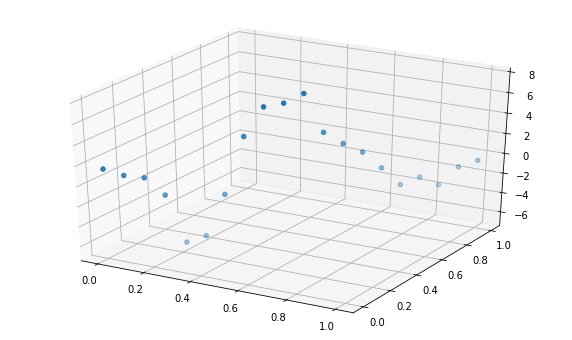

100%|██████████| 1999/1999 [00:02<00:00, 716.33it/s]


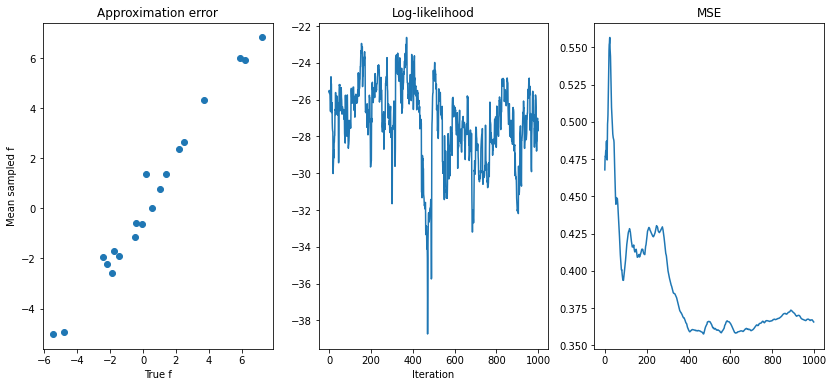

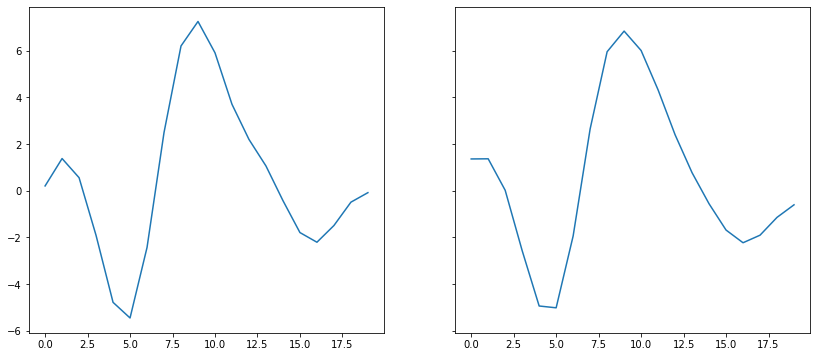

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm

np.random.seed(8)


class EllipticalSliceSampler:
    """Elliptical Slice Sampler Class
    
    The elliptical slice sampling algorithm is a Markov chain Monte Carlo
    approach to sampling from posterior distributions that consist of an
    arbitrary likelihood times a multivariate normal prior. The elliptical
    slice sampling algorithm is advantageous because it is conceptually simple 
    and easy to implement and because it has no free parameters.

    The algorithm operates by randomly selecting a candidate from an ellipse
    defined by two vectors, one of which is assumed to be drawn from the target
    posterior and another that is an auxiliary random sample of a zero-mean
    multivariate normal. The algorithm iteratively shrinks the range from which
    candidates can be drawn until a candidate proposal is accepted.
    """
    def __init__(self, covariance, log_likelihood_func):
        """Initialize the parameters of the elliptical slice sampler object.

        Parameters:
        mean (numpy array): A mean vector of a multivariate Gaussian.
        covariance (numpy array): A two-dimensional positive-definite
            covariance matrix of a multivariate Gaussian.
        log_likelihood_func (function): A log-likelihood function that maps
        a given sample (as its exclusive input) to a real number
        reflecting the log-likelihood of the observational data under
        the input parameter.
        """
        self.covariance = covariance
        self.log_likelihood_func = log_likelihood_func

    def __sample(self, f):
        """Internal Function that draws an individual sample according to the
        elliptical slice sampling routine. The input is drawn from the target
        distribution and the output is as well.

        Parameters:
        f (numpy array): A vector representing a parameter state that has
        been sampled from the target posterior distribution. Note that
        a sufficently high 'burnin' parameter can be leveraged to
        achieve a good mixin for this purpose.
        """
        # Choose the ellipse for this sampling iteration.
        nu = np.random.multivariate_normal(np.zeros(self.covariance.shape[:1]), self.covariance)
        # print("nu", nu, nu.shape)
        # Set the candidate acceptance treshold.
        log_y = self.log_likelihood_func(f) + np.log(np.random.uniform())
        # Set the bracket for selecting candidates on the ellipse.
        theta = np.random.uniform(0., 2.*np.pi)
        theta_min, theta_max = theta - 2.*np.pi, theta

        # Iterates until a candidate is selected.
        while True:
            # Generates a point on the ellipse defined by 'nu' and the input. We
            # also compute the log-likelihood of the candidate and compare to
            # our threshold.
            fp = (f)*np.cos(theta) + nu*np.sin(theta)
            log_fp = self.log_likelihood_func(fp)
            if log_fp > log_y:
                return fp
            else:
                # If the candidate is not selected, shrink the bracket and
                # generate a new 'theta', which will yield a new candidate
                # point on the ellipse.
                if theta < 0.:
                    theta_min = theta
                else:
                    theta_max = theta
                theta = np.random.uniform(theta_min, theta_max)
                if theta_max-theta_min == 0:
                    print("should stop")
      
    def sample(self, n_samples, initial_state, burnin=1000):
        """This function is user-facing and is used to generate a specified
        number of samples from the target distribution using elliptical slice
        sampling. The 'burnin' parameter defines how many iterations should be
        performed (and excluded) to achieve convergence to the target
        distribution.

        Parameters:
            n_samples (int): The number of samples to produce from this sampling
            routine.
            burnin (int, optional): The number of burnin iterations to perform.
            This is necessary to achieve samples that are representative of
            the true posterior and correctly characterize uncertainty.
        """
        # Compute the total number of samples.
        total_samples = n_samples + burnin
        # Initialize a matrix to store the samples. The first sample is chosen
        # to be a draw from the multivariate normal prior.
        samples = np.zeros((total_samples, self.covariance.shape[0]))
        samples[0] = np.zeros(self.covariance.shape[:1]) if initial_state is None else initial_state
        for i in tqdm(range(1, total_samples)):
            samples[i] = self.__sample(samples[i-1])
        return samples[burnin:]

def main():
    # Set the mean and variance of two Gaussian densities. The first of these will be
    # regarded as the prior, while the second will represent the likelihood.
    # Fortunately, the product of two Gaussian densities can be regarded as an
    # Unnormalized Gaussian density with closed-form expressions for the mean
    # and variance.

    def sq_exp(x1, x2, params=None):    
        if params is None:
            params = dict()
        length_scale = params.get('length_scale', 1.0)
        signal_variance = params.get('signal_variance', 1.0)
        return signal_variance*np.exp(-np.sum((x1-x2)**2) / (2*length_scale**2))

    N = 20
    D = 1
    x = np.expand_dims(np.linspace(0, 1, N), 1)
    noise_var = 1.0 
    
    K = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            K[i, j] = 5.0 * sq_exp(x[i], x[j], {"length_scale": 0.1})

    jitter = 1e-6 * np.eye(N)
    L = np.linalg.cholesky(K + jitter)
    z = np.random.normal(size=(N,))
    f_prior = np.squeeze(np.dot(L, z))
    data = np.random.normal(loc=f_prior, scale=noise_var)

    fig = plt.figure(figsize=(10,6))
    ax = fig.gca(projection='3d')
    ax.scatter(x[:,0], x[:,0], data)
    plt.show()

    def logLikFunc(f):
        result = np.sum(norm.logpdf(data, loc=f, scale=noise_var))
        return result

    ess = EllipticalSliceSampler(K, logLikFunc)
    nsamples = 1000
    f_samples = ess.sample(nsamples, None)
    f_exp = np.mean(f_samples, axis=0)
    error_running = [
        np.mean(np.abs(f_prior - np.mean(f_samples[0:i], axis=0)))
        for i in range(1,nsamples)
    ]

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))
    ax1.scatter(f_prior, f_exp)
    ax1.set_xlabel("True f")
    ax1.set_ylabel("Mean sampled f")
    ax1.set_title("Approximation error")
    ax2.plot([logLikFunc(s) for s in f_samples])
    ax2.set_xlabel("Iteration")
    ax2.set_title("Log-likelihood")
    ax3.plot(error_running)
    ax3.set_title("MSE")

    if D == 1:

        fig, (ax1, ax2) = plt.subplots(
            nrows=1, ncols=2, figsize=(14, 6), sharex=True, sharey=True
        )
        ax1.plot(f_prior)
        ax2.plot(np.mean(f_samples, axis=0))

        plt.show()


main()